In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120) 
              ,(214, 39, 40), (255, 152, 150),(44, 160, 44), (152, 223, 138)
              , (140, 86, 75), (196, 156, 148), (148, 103, 189), (197, 176, 213)
            , (23, 190, 207), (158, 218, 229) #light blue
             ,(227, 119, 194), (247, 182, 210)  #light green
             , (188, 189, 34), (219, 219, 141)  #pink
             ,(127, 127, 127), (199, 199, 199) #grey
              
            ]
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:

method_list = ['SSD','yolo','faster-rcnn','mask-rcnn']  #results/yolo, results_new/faster-rcnn2, results_new/mask-rcnn
method_name = ['SSD','YOLO','faster R-CNN','Mask R-CNN']

dataset = 'Pathway1_1'
iou_folder = 'iou' #1-1  310-548
det_folder = 'results'
channel_list = [2,4,6]
image_num=548
TH=0.5
start_frame=350
end_frame = 545



In [14]:

def read_iou_data(method):
    iou_mat = [[0 for x in range(image_num)] for y in range(len(channel_list))]
    #iou_dict =[{} for i in range(len(channel_list))]


    for idx,channel in enumerate(channel_list):
        filename = iou_folder+"/"+method+'_ch'+str(channel)+"_"+dataset+"_iou.txt"
        with open(filename, 'r') as csvfile:
            rows = csv.reader(csvfile)
            for row in rows:        

                frame_num = int(row[0])        
                iou = float(row[1])    

                if(iou>TH):
                    iou_mat[idx][frame_num] = iou
                #iou_dict[idx][frame_num]=iou
                #sorted(iou_dict)
                #print('frame_num={}, iou={}'.format(frame_num,iou))

        csvfile.close()
    return iou_mat

In [12]:
def conf_mat_gen(filename):
    confidence_mat = [[0 for x in range(image_num)] for y in range(len(channel_list))]
    with open(filename, 'r') as csvfile:

    # 讀取 CSV 檔案內容
        rows = csv.reader(csvfile)
    # 以迴圈輸出每一列
        for row in rows:        
            if int(row[0]) in channel_list:
                channel_idx = channel_list.index(int(row[0]) )       
                img = int(row[1])

                type = row[7].strip()

                if(type == 'person'):


                    confidence = row[6]
                    confidence_mat[channel_idx][img] = float(confidence)

                    startX = int(float(row[2]))
                    startY = int(float(row[3]))
                    endX = int(float(row[4]))
                    endY = int(float(row[5]))



    csvfile.close()
    return confidence_mat

In [6]:
def cont_range(confident_mat,th):
    
    start=0
    end=0
    tag=False
    my_list=[]
    for idx,conf in enumerate(confident_mat):
        #print(idx)
        if tag==False and conf>th:
            start=idx
            end=idx
            tag=True
            #print("[1]"+str(start)+","+str(end))
        elif tag==True and conf>th:
            end=idx
            #print("[2]"+str(start)+","+str(end))
        
        if tag==True and (conf<th or idx==np.size(confident_mat)-1):
            tag=False
            #print("[3]"+str(start)+","+str(end))
            if end-start>10:
                my_list.append((start,end))
            
    return my_list

In [7]:
def plot_iou(mname,iouMat,th):
    fig, axs = plt.subplots(3, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

    line=[]
    for idx,ch in enumerate(channel_list):            
        x = range(start_frame,end_frame)  
        
        y = iouMat[idx][start_frame:end_frame]     
        
        y1= signal.medfilt(y,3)    
        range_list =cont_range(y1,th)
        y2=y1.copy()
        for r in range_list:
            Y=np.zeros(end_frame-start_frame)        
            Y=y1[r[0]:r[1]+1]
            X=x[r[0]:r[1]+1]
            y2[r[0]:r[1]+1]=-1           
            #print(y2)
            fig_tmp, = axs[idx].plot(X,Y,label="channel"+str(ch),color=tableau20[ch])
            line.append(fig_tmp)
            

        
        axs[idx].set_ylabel("channel "+str(ch), size =12)
        axs[idx].scatter(x,y2,s=5,color=tableau20[ch],alpha=0.2)    

        
        for ax in axs:
            ax.label_outer()
            ax.set_ylim(0,1.1)
            ax.set_xlim(start_frame,image_num)
        
    fig.suptitle(mname+' IoU', fontsize=12)    
    fig.savefig(method+'_iou.png', bbox_inches='tight')


In [8]:
def plot_scatter_conf(mname,confidence_mat,th):
    fig, axs = plt.subplots(3, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
    #fig = plt.figure(figsize=(8,4), dpi= 80)  
    x=range(start_frame,image_num)
    line =[]
    for idx,ch in enumerate(channel_list):            

        y = confidence_mat[idx][start_frame:]           
        y1= signal.medfilt(y,3)      
        range_list =cont_range(y1,th)   # (1) cont_range   (2) plot_count
        y2=y1.copy()
        #print(y2)
        #line_count=0
        for r in range_list:
            Y=np.zeros(image_num-start_frame)        
            Y=y1[r[0]:r[1]+1]
            X=x[r[0]:r[1]+1]
            y2[r[0]:r[1]+1]=-1           
            #print(y2)
            fig_tmp, = axs[idx].plot(X,Y,label="channel"+str(ch),color=tableau20[ch])
            line.append(fig_tmp)
            #line_count=line_count+1
        axs[idx].set_ylabel("channel "+str(ch), size =12)
        axs[idx].scatter(x,y2,s=5,color=tableau20[ch],alpha=0.2)    
            
            
        
    for ax in axs:
        ax.label_outer()
        ax.set_ylim(0,1.1)
        ax.set_xlim(start_frame,image_num)
    
    #fig.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    fig.suptitle(mname, fontsize=12)
    
    fig.savefig(method+'.png', bbox_inches='tight')

    
  

In [9]:
def plot_together(mname,confidence_mat,conf_th,iouMat,iou_th):
    fig, axs = plt.subplots(3, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
    #fig = plt.figure(figsize=(8,4), dpi= 80)  
    x=range(start_frame,end_frame)
    line =[]
    for idx,ch in enumerate(channel_list):            

        y = confidence_mat[idx][start_frame:end_frame]   
        y1= signal.medfilt(y,3)      
        range_list =cont_range(y1,conf_th)   # (1) cont_range   (2) plot_count
        y2=y1.copy()
        
        z = iouMat[idx][start_frame:end_frame]     
        z1= signal.medfilt(z,3)    
        iou_list =cont_range(z1,iou_th)
        z2=z1.copy()
        for r in range_list:
            Y=np.zeros(end_frame-start_frame)        
            Y=y1[r[0]:r[1]+1]
            X=x[r[0]:r[1]+1]
            y2[r[0]:r[1]+1]=-1           
            #print(y2)
            fig_tmp, = axs[idx].plot(X,Y,label="channel"+str(ch),color=tableau20[idx*4])
            
            line.append(fig_tmp)
                    
        
        #print(y2)
        #line_count=0
        for r in iou_list:
            Z=np.zeros(end_frame-start_frame)        
            Z=z1[r[0]:r[1]+1]
            X=x[r[0]:r[1]+1]
            z2[r[0]:r[1]+1]=-1           
            #print(y2)
            fig_tmp, = axs[idx].plot(X,Z,label="channel"+str(ch),color=tableau20[idx*4+2])
            
            line.append(fig_tmp)
            #line_count=line_count+1
            
        axs[idx].set_ylabel("channel "+str(ch), size =12)
        axs[idx].scatter(x,y2,s=5,color=tableau20[idx*4],alpha=0.2)    
        axs[idx].scatter(x,z2,s=5,color=tableau20[idx*4+2],alpha=0.2)    
            
            
        
    for ax in axs:
        ax.label_outer()
        ax.set_ylim(0,1.1)
        ax.set_xlim(start_frame,image_num)
    
    #fig.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    fig.suptitle(mname, fontsize=12)
    
    fig.savefig(method+'.png', bbox_inches='tight')
    

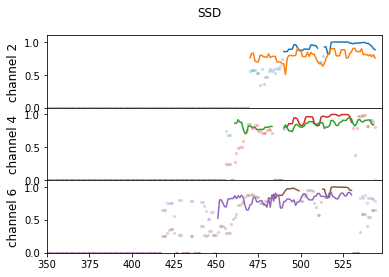

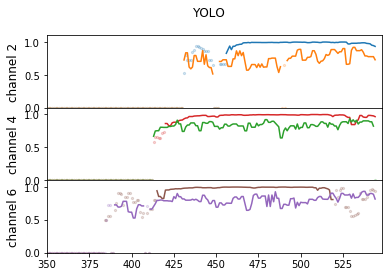

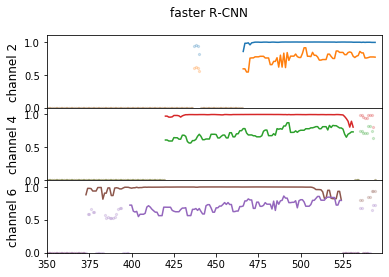

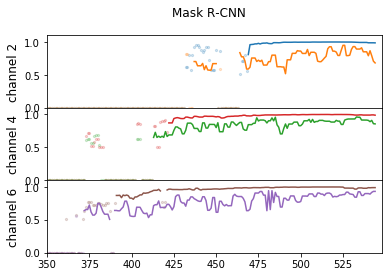

In [15]:
for i,method in enumerate(method_list):
    m_name = method_name[i]
    iouMat = read_iou_data(method)  
    filename = det_folder+"/"+method+"_"+dataset+".txt"
    conf_mat = conf_mat_gen(filename)
    
    #plot_scatter_conf(m_name,conf_mat,0.8)
    
    #plot_iou(m_name,iouMat,0.5)
    plot_together(m_name,conf_mat,0.8,iouMat,0.5)